## This notebook explores the effect of the reaction space size on the results.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import skew
import os
import ast
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

wdir = Path(".")

## Create subsets of the data

To investigate this effect, we performed stratified sampling using the rate labels to get smaller subdatasets that have approximately the same distribution.

The full, unfiltered datast has 2055 entries.


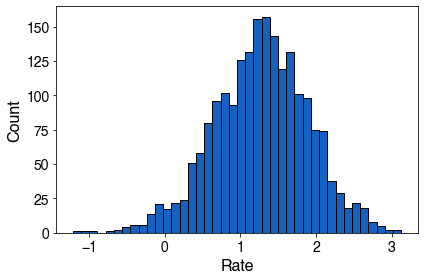

In [2]:
# Read in the unfiltered dataset
df_original = pd.read_csv("./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered.csv",index_col=0,header=0)
print(f"The full, unfiltered datast has {len(df_original)} entries.")
plt.figure(figsize=(6, 4))
plt.hist(df_original["rate"], color=all_colors[1], bins=40, edgecolor="k")
plt.xlabel("Rate")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

In [ ]:
# define a function for the sampling
def stratified_sampling(df, fraction, n_bins, col='rate', random_state=42):
    # create equally sized bins
    df = df.copy(deep=True)
    df['bin'] = pd.qcut(df[col], q=n_bins, duplicates='drop', labels=False)
    
    # Setup stratified sampler
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=fraction, random_state=random_state)
    strat_sample = None
    # Get indices for stratified sample
    for train_idx, _ in splitter.split(df, df['bin']):
        strat_sample = df.iloc[train_idx]
        
    # Drop helper column before returning
    strat_sample = strat_sample.drop(columns=['bin'])
    
    return strat_sample

In [4]:
# create datasets with different sizes and save them
dfs_subsets = {1: df_original}
fractions = [0.75,0.5,0.25]
for fraction in fractions:
    dfs_subsets[fraction] = stratified_sampling(df=df_original,fraction=fraction,n_bins=80)
    dfs_subsets[fraction].to_csv(f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_filtered{int(fraction*2055)}.csv",index=True,header=True)
fractions = [1] + fractions

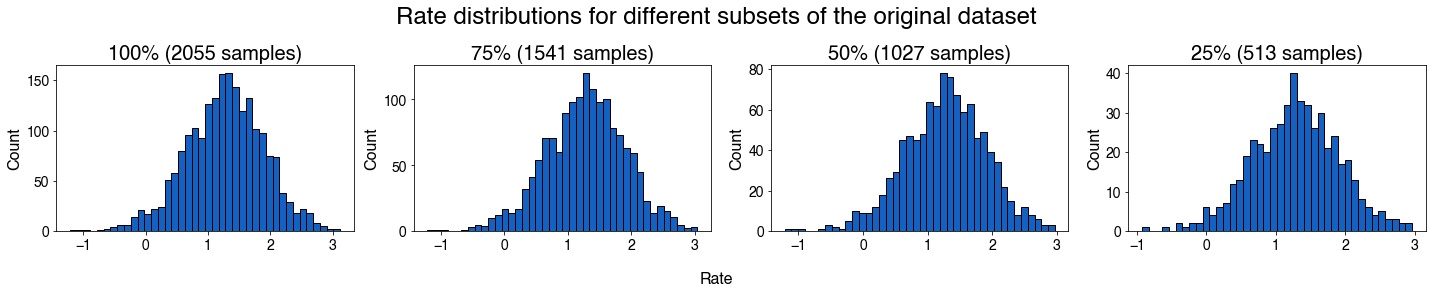

In [5]:
# Plot the distributions
fig, axes = plt.subplots(1, len(fractions), figsize=(20, 4), sharey=False)
fig.suptitle("Rate distributions for different subsets of the original dataset",fontsize=24)
fig.supxlabel("Rate",fontsize=16)
for i,fraction in enumerate(fractions):
    axes[i].hist(dfs_subsets[fraction]["rate"], color=all_colors[1], bins=40, edgecolor="k")
    plt.ylabel("Count")
    plt.tick_params(axis='both', which='major')
    axes[i].set_title(f"{round(fraction*100)}% ({len(dfs_subsets[fraction])} samples)",fontsize=20)
    axes[i].set_ylabel("Count")
plt.tight_layout()
plt.show()

In [6]:
# Check the statistics for each dataset:
for df in dfs_subsets.values():
    print(f"Dataset with {len(df)} samples")
    print(f"Mean rate: {round(df['rate'].mean(),4)}")
    print(f"Max rate: {round(df['rate'].max(),4)}")
    print(f"Min rate: {round(df['rate'].min(),4)}")
    print(f"Skewness: {round(skew(df['rate']),4)}")
    print("")


Dataset with 2055 samples
Mean rate: 1.2726
Max rate: 3.123
Min rate: -1.214
Skewness: -0.1804

Dataset with 1541 samples
Mean rate: 1.2714
Max rate: 3.044
Min rate: -1.214
Skewness: -0.2001

Dataset with 1027 samples
Mean rate: 1.2711
Max rate: 2.968
Min rate: -1.214
Skewness: -0.2344

Dataset with 513 samples
Mean rate: 1.275
Max rate: 2.962
Min rate: -0.931
Skewness: -0.1241



The mean rate of all datasets is essentially the same. Despite smaller differences in the extreme values and the skewness of the datasets, they are very similar.

## Run scopes with the subsets

In [ ]:
# # for smaller subsets of the dataset, the reaction space exhausts quicker with same pruning --> remove combinations that would prune too much
# pruned_combis = [(0.5,2), (0.25,2), (0.25,3), (0.25,4)]
# for fraction in fractions[1:]:  # Skip the full,unfiltered dataset (first list entry) since it was already run in another notebook
#     # dictionary with the different batches and the possible Vendi pruning fractions (larger batch = less rounds --> more pruning possible)
#     batch_pruning_combinations = {2: [0,10,20,30], 3: [0,10,20,30,40], 4: [0,10,20,30,40,50]}
#     for batch in batch_pruning_combinations.keys():
#         if (fraction,batch) in pruned_combis:
#             # remove the highest pruning percentages as it is not tolerated for this subdataset - batch size combination
#             batch_pruning_combinations[batch].pop()
#         # run the scopes with the different settings
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_filtered{int(fraction*2055)}.csv",  
#             name_results = f"./Results_Data/Reaction_Space_Size_Dependence/Filtered_Reaction_Space{int(fraction*2055)}/30balanced_b{batch}",  
#             objectives=['rate'],  
#             budget = 30,
#             batches= [batch],
#             Vendi_pruning_fractions = batch_pruning_combinations[batch],
#             seeds = 20,
#             acquisition_function_mode= "balanced",
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random",
#             filename_prediction="df_tuning.csv")

## Analyze the data

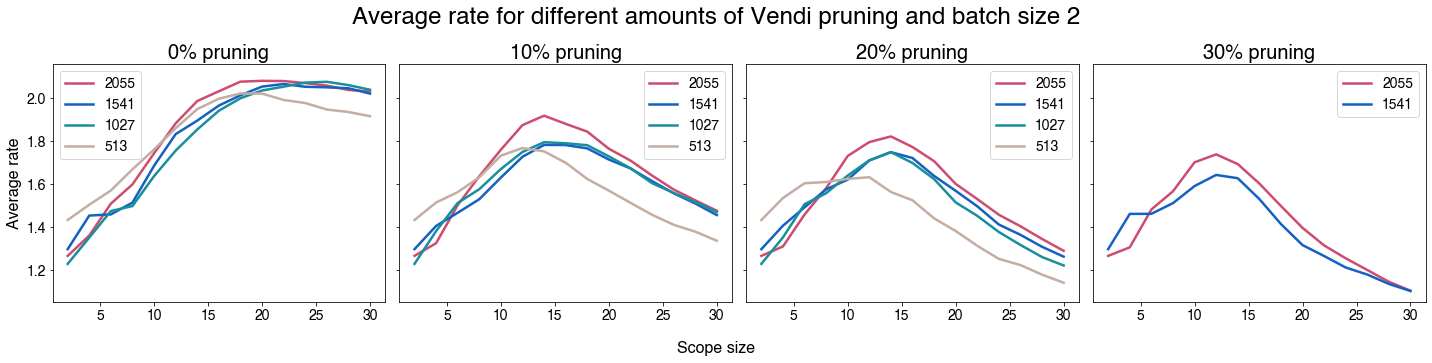

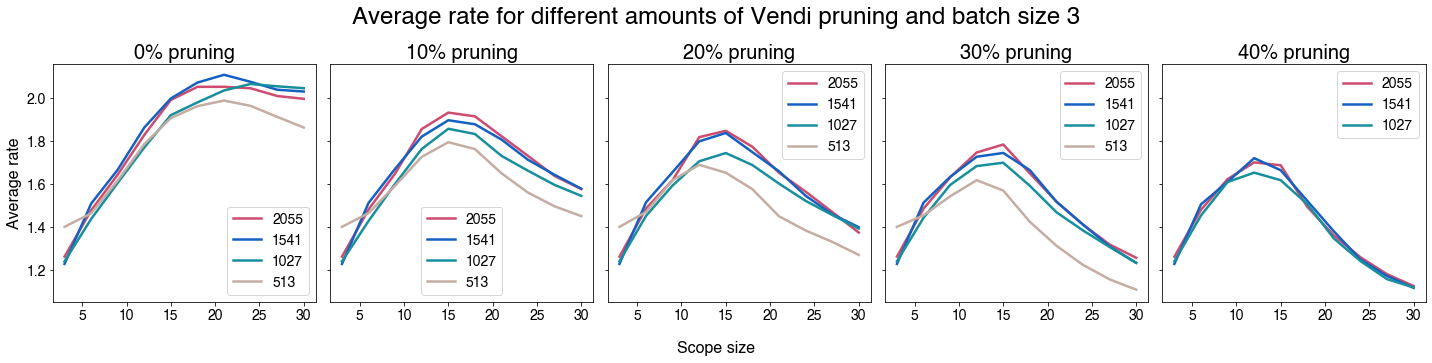

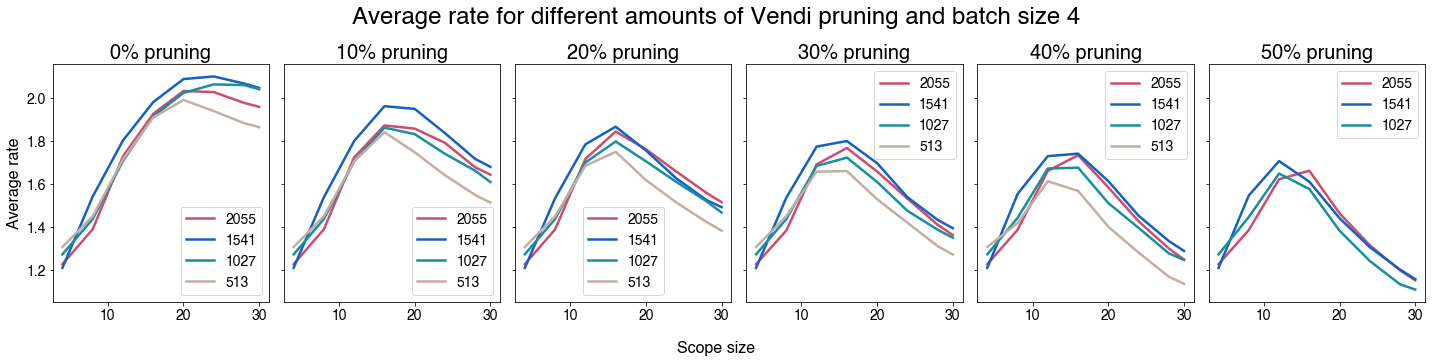

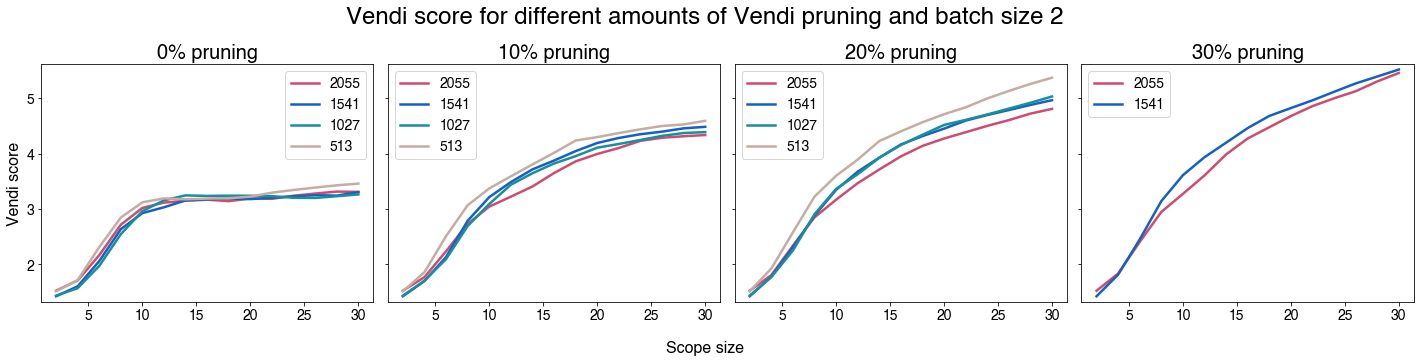

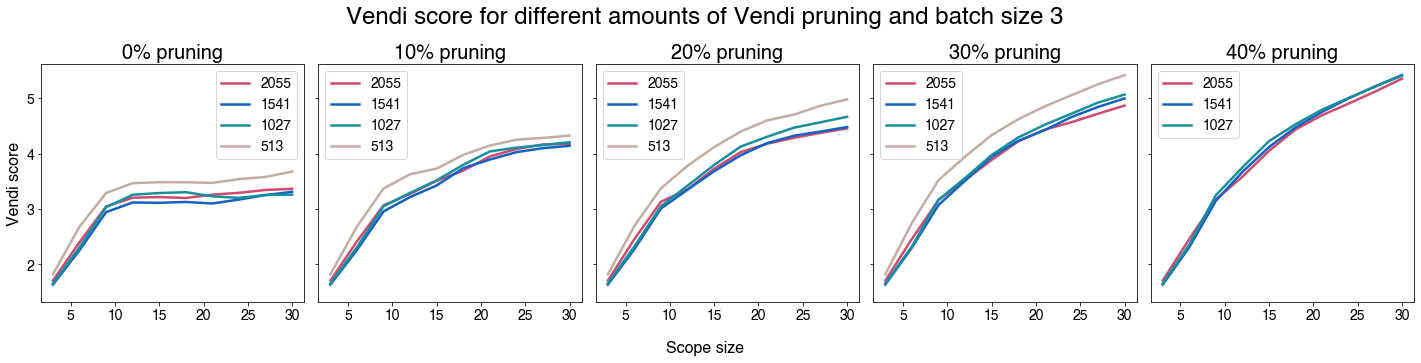

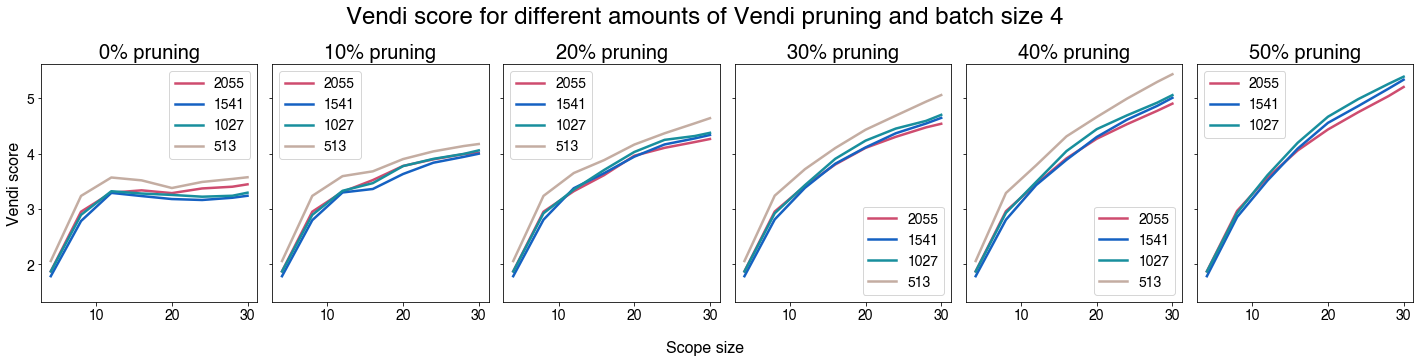

In [8]:
# Process the data
for type_results in ["Objective","Vendi"]:
    label = None
    dfs = {}
    for folder in ["Full_Reaction_Space","Filtered_Reaction_Space1541","Filtered_Reaction_Space1027","Filtered_Reaction_Space513"]:
        if folder == "Full_Reaction_Space":
            label = 2055
        else: 
            label = int(folder[23:])  # Remove the tag "Filtered_Reaction_Space" from the filename
        for i in [2,3,4]:
                dfs_progress =  Benchmark().progress_plot(budget=30,type_results=type_results,
                                                                            name_results=f"./Results_Data/Reaction_Space_Size_Dependence/{folder}/30balanced_b{i}",
                                                                            show_plot=False)
                dfs[str(label)+"_b"+str(i)] = dfs_progress["means"]

    # Concatenate the results
    df = pd.concat(dfs,axis=1)
    # Clean up the multi-index that resulted from concatenation
    df.columns = [multiidx[0].split("_")[0]+"_"+multiidx[1] for multiidx in df.columns]

    # Visualize them
    batch_pruning_combinations = {2: [0,10,20,30], 3: [0,10,20,30,40], 4: [0,10,20,30,40,50]}
    for batch in [2,3,4]:
        fig, axes = plt.subplots(1, len(batch_pruning_combinations[batch]), figsize=(20, 5), sharey=True)
        fig.supxlabel("Scope size",fontsize=16)
        if type_results == "Objective":
            fig.suptitle(f"Average rate for different amounts of Vendi pruning and batch size {batch}",fontsize=24)
            axes[0].set_ylabel("Average rate",fontsize=16)
        elif type_results == "Vendi":
            extreme_scores = (df.min().min(),df.max().max())
            fig.suptitle(f"Vendi score for different amounts of Vendi pruning and batch size {batch}")
            axes[0].set_ylabel("Vendi score",fontsize=16)
        for i,pruning in enumerate(batch_pruning_combinations[batch]):
            if type_results == "Objective":
                extreme_scores = (df.min().min()-0.05,df.max().max()+0.05)
            if type_results == "Vendi":
                extreme_scores = (df.min().min()-0.1,df.max().max()+0.1)
            df_plot = df.copy()
            df_plot = df_plot[[column for column in df.columns if ((f"b{batch}_V{pruning}") in column)]]
            df_plot.columns = [col.split("_")[0] for col in df_plot.columns]
            for j,col in enumerate(df_plot.columns):
                style = '-' if j <= 6 else '--' if j <= 13 else ':'
                plotting = df_plot[col][df_plot[col].notna()]
                axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
            axes[i].set_ylim(extreme_scores[0],extreme_scores[1])
            axes[i].tick_params(labelsize=14)
            axes[i].set_title(f"{pruning}% pruning",fontsize=20)
            axes[i].legend(fontsize=14,title_fontsize=14)
        plt.tight_layout()
        plt.show()

Average objectives: Decreasing search space size leads to lowered performance at the same amount of Vendi pruning.

Vendi scores: Smaller search space sizes lead to higher Vendi scores at the same amout of Vendi pruning

In conclusion, the size of the reaction space has only a small effect on the results if the size difference is not very large.